<a href="https://colab.research.google.com/github/viniciusrpb/cloud_image_classification/blob/main/cloud_classification_swimcat_inceptvionv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# New Section

In [2]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.0 MB/s 


In [3]:
!cp -r "/content/drive/My Drive/img_satelite/classificacao/SWIMCAT/train" "training"
!cp -r "/content/drive/My Drive/img_satelite/classificacao/SWIMCAT/val" "validation"
!cp -r "/content/drive/My Drive/img_satelite/classificacao/SWIMCAT/test" "testing"

In [4]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,GlobalAveragePooling2D ,MaxPooling2D,Activation,Flatten,Conv2D,BatchNormalization,Dropout
from tensorflow.keras import layers
from tensorflow.keras import Model
import keras.applications
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
import os
import argparse


In [5]:
path_train = 'training'
path_validation = 'validation'
path_test = 'testing'

# Pretrained GoogLeNet model using ImageNet


Hyperparameters

In [6]:
batch_size = 32
epochs=15
dim = (224,224)

In [7]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from tensorflow.keras.applications.resnet50 import ResNet50

pre_trained_model = InceptionV3(input_shape=(224,224,3),include_top=False,pooling ='avg',weights='imagenet')
#pre_trained_model = ResNet50(input_shape=(224,224,3),include_top=False,pooling ='avg',weights='imagenet', classes=11)

for layer in pre_trained_model.layers:
  layer.trainable = False

87924736/87910968 [==============================] - 1s 0us/step


### Data augmentation

In [8]:
train_datagen = ImageDataGenerator(rescale=1. / 255)

validation_datagen = ImageDataGenerator(rescale=1. / 255)

test_datagen = ImageDataGenerator(rescale=1. / 255)


Read the images

In [9]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(path_train,
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical', 
                                                    target_size = (224,224))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  validation_datagen.flow_from_directory( path_validation,
                                                          batch_size  = batch_size,
                                                          class_mode  = 'categorical', 
                                                          target_size = (224,224))

test_generator =  test_datagen.flow_from_directory( path_test,
                                                          batch_size  = batch_size,
                                                          class_mode  = 'categorical', 
                                                          target_size = (224,224))

Found 546 images belonging to 5 classes.
Found 76 images belonging to 5 classes.
Found 162 images belonging to 5 classes.


Hyper-parameters

In [10]:
number_of_neurons = 512
number_of_classes = 5

Lets see some samples

In [11]:
model = Sequential()

model.add(pre_trained_model)
model.add(BatchNormalization())
#model.add(GlobalAveragePooling2D())
#model.add(Flatten())

# 1st hidden layer: 300 neurons
#model.add(Dense(number_of_neurons,activation="relu"))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())

# 2nd hidden layer : 150 neurons
#model.add(Dense(number_of_neurons//2,activation="relu"))
#model.add(Dropout(0.5))
#model.add(BatchNormalization())


# 3rd hidden layer : 75 neurons
#model.add(Dense(number_of_neurons,activation="relu"))
#model.add(Dropout(0.5))
#model.add(BatchNormalization())

model.add(Dense(number_of_classes,activation="softmax"))

In [12]:
sgd = SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)

f1_score = tfa.metrics.F1Score(num_classes=number_of_classes, average='macro',threshold=0.5)

model.compile(optimizer = sgd, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy',f1_score])

#model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005,decay = 1e-6), 
#              loss = 'categorical_crossentropy', 
#              metrics = ['accuracy',f1_score])
            #metrics = ['accuracy',f1_score])



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Callbacks definition to reduce chances of overfitting the model

In [13]:
fname = "weights-inceptionv3-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"

resnet_checkpoint = ModelCheckpoint(fname, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

resnet_early_stopping = EarlyStopping(monitor='loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
callbacklist = [resnet_checkpoint,resnet_early_stopping,reduce_lr]

In [14]:
history_fine = model.fit(train_generator,
                         epochs=epochs,
                         batch_size=batch_size,
                         validation_data=validation_generator,
                         callbacks=callbacklist
                         )

Epoch 1/15
18/18 [==============================] - ETA: 0s - loss: 0.6093 - accuracy: 0.8040 - f1_score: 0.7844
Epoch 1: val_accuracy improved from -inf to 0.92105, saving model to weights-inceptionv3-improvement-01-0.92.hdf5
18/18 [==============================] - 80s 4s/step - loss: 0.6093 - accuracy: 0.8040 - f1_score: 0.7844 - val_loss: 0.4174 - val_accuracy: 0.9211 - val_f1_score: 0.8946 - lr: 0.0100
Epoch 2/15
18/18 [==============================] - ETA: 0s - loss: 0.0651 - accuracy: 0.9762 - f1_score: 0.9736
Epoch 2: val_accuracy improved from 0.92105 to 0.94737, saving model to weights-inceptionv3-improvement-02-0.95.hdf5
18/18 [==============================] - 66s 4s/step - loss: 0.0651 - accuracy: 0.9762 - f1_score: 0.9736 - val_loss: 0.2803 - val_accuracy: 0.9474 - val_f1_score: 0.9051 - lr: 0.0100
Epoch 3/15
18/18 [==============================] - ETA: 0s - loss: 0.0166 - accuracy: 0.9963 - f1_score: 0.9967
Epoch 3: val_accuracy did not improve from 0.94737
18/18 [====

In [15]:
#f1 = history_fine.history['f1_score']
#val_f1 = history_fine.history['val_f1_score']

#plt.figure(figsize=(8, 8))
#plt.subplot(2, 1, 1)
#plt.plot(f1, label='Training F1-Score')
#plt.plot(val_f1, label='Validation F1-Score')
#plt.legend(loc='lower right')
#plt.ylabel('F1-Score')
#plt.ylim([min(plt.ylim()),1])
#plt.title('Training and Validation F1-Score')


Text(0.5, 1.0, 'Training and Validation F1-Score')

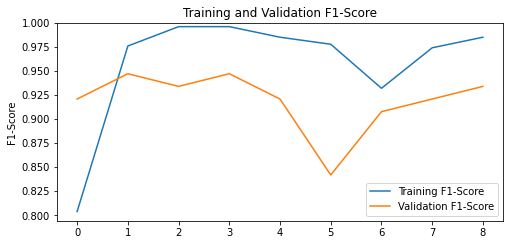

In [16]:
f1 = history_fine.history['accuracy']
val_f1 = history_fine.history['val_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(f1, label='Training F1-Score')
plt.plot(val_f1, label='Validation F1-Score')
plt.legend(loc='lower right')
plt.ylabel('F1-Score')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation F1-Score')


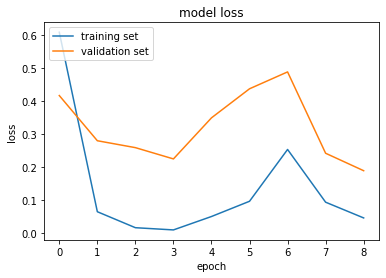

In [17]:
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper left')
plt.show()

In [18]:
score = model.evaluate(test_generator,batch_size=batch_size) 
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

6/6 [==============================] - 17s 3s/step - loss: 0.2102 - accuracy: 0.9506 - f1_score: 0.9292
Test loss: 0.2102261334657669 / Test accuracy: 0.9506173133850098


In [19]:
#y_prob = model.predict(test_generator,batch_size=batch_size)
#y_pred = np.argmax(y_prob,axis=1)

y_prob = model.predict(test_generator)
y_pred = np.argmax(y_prob,axis=1)
#print(pred, labels[np.argmax(pred)])
print(classification_report(test_generator.classes,y_pred))

              precision    recall  f1-score   support

           0       0.29      0.30      0.29        46
           1       0.22      0.21      0.22        19
           2       0.32      0.31      0.32        51
           3       0.11      0.11      0.11        28
           4       0.06      0.06      0.06        18

    accuracy                           0.23       162
   macro avg       0.20      0.20      0.20       162
weighted avg       0.23      0.23      0.23       162



In [20]:
y_prob

array([[9.98448968e-01, 5.65518974e-04, 4.83706426e-05, 8.78896099e-04,
        5.83662222e-05],
       [1.68489223e-10, 7.45269124e-10, 3.67047642e-06, 9.99592960e-01,
        4.03404905e-04],
       [2.08502650e-04, 9.94139194e-01, 7.67707970e-05, 2.60135415e-03,
        2.97422591e-03],
       [1.25601528e-05, 5.77298852e-05, 9.99679089e-01, 8.86104499e-06,
        2.41788890e-04],
       [9.92752075e-01, 1.87188992e-03, 2.69963895e-03, 2.42560264e-03,
        2.50757090e-04],
       [9.92537200e-01, 1.85291399e-03, 2.02705734e-03, 1.66536181e-03,
        1.91747700e-03],
       [2.12340208e-08, 1.63466859e-06, 1.42895374e-06, 9.99155879e-01,
        8.40972061e-04],
       [6.20084465e-05, 5.58868051e-03, 6.33211061e-02, 8.19090247e-01,
        1.11937918e-01],
       [2.03838642e-03, 2.71065626e-04, 9.97560143e-01, 1.18897689e-04,
        1.15786925e-05],
       [4.08248918e-04, 6.37338017e-05, 9.99488711e-01, 2.98749092e-05,
        9.36928518e-06],
       [9.99001801e-01, 1.3395

In [21]:
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4], dtype=int32)

In [22]:
y_pred

array([0, 3, 1, 2, 0, 0, 3, 3, 2, 2, 0, 1, 4, 0, 1, 2, 0, 2, 0, 4, 0, 0,
       3, 2, 2, 2, 4, 4, 3, 0, 2, 3, 1, 3, 2, 2, 1, 3, 0, 0, 3, 2, 2, 3,
       0, 0, 0, 1, 3, 2, 2, 1, 2, 0, 0, 2, 1, 0, 2, 0, 3, 0, 2, 3, 1, 3,
       3, 0, 0, 4, 4, 2, 3, 2, 3, 2, 0, 2, 2, 2, 2, 0, 1, 2, 2, 2, 4, 0,
       0, 0, 0, 4, 1, 2, 4, 3, 0, 1, 0, 0, 2, 3, 2, 4, 0, 2, 4, 4, 2, 4,
       4, 3, 3, 2, 4, 3, 1, 1, 0, 2, 2, 4, 2, 0, 3, 2, 1, 0, 3, 2, 2, 0,
       1, 3, 2, 2, 2, 1, 0, 0, 0, 0, 2, 0, 3, 0, 4, 0, 1, 3, 2, 2, 2, 0,
       2, 2, 0, 0, 0, 0, 3, 0])

In [23]:
import plotly.figure_factory as ff

y_true = test_generator.classes

z = confusion_matrix(y_true, y_pred)

x = list(test_generator.class_indices.keys())

y = list(test_generator.class_indices.keys())


In [24]:
# change each element of z to type string for annotations
z_text = [[str(y) for y in x] for x in z]

# set up figure 
fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

# add title
fig.update_layout(title_text='<i><b>Confusion matrix</b></i>',
                  #xaxis = dict(title='x'),
                  #yaxis = dict(title='x')
                 )

# add custom xaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=0.5,
                        y=-0.15,
                        showarrow=False,
                        text="Predicted value",
                        xref="paper",
                        yref="paper"))

# add custom yaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=-0.35,
                        y=0.5,
                        showarrow=False,
                        text="Real value",
                        textangle=-90,
                        xref="paper",
                        yref="paper"))

# adjust margins to make room for yaxis title
fig.update_layout(margin=dict(t=50, l=200))

# add colorbar
fig['data'][0]['showscale'] = True
fig.show()